## Classification with Logistic Regression, LDA/QDA, and Trees

Hillary Cheruiyot

<hr style="height:2pt">



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

'''Addidtional Sources'''

from sklearn import preprocessing
from sklearn import linear_model
from sklearn import discriminant_analysis as da
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from IPython.core.display import HTML

## Part 1: Overview of Multiclass Thyroid Classification

In this project we will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw7.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was [obtained from the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Thyroid+Disease); for this assignment we chose two predictors so we can visualize the decision boundaries.

Notice that the task at hand is a 3-class classification problem. We will explore different methods for multiclass classification.

For most of this problem set, we'll measure overall classification accuracy as the fraction of observations classified correctly.

**1.1** Load the data and examine its structure. How many instances of each class are there in our dataset? In particular, what is the ratio of the number of observations in class 2 (hyperthyroidism) to the number of observations in class 3 (hypothyroidism)? We'll refer to this as the *hyper-to-hypo ratio*.

Let's read our full dataset.

In [2]:
df_thyroid = pd.read_csv('data/dataset_hw7.csv')

In [3]:
display(HTML('The dataset has {} observations with {} features'.format(df_thyroid.shape[0], df_thyroid.shape[1])))

In [4]:
df_thyroid.describe()

,Biomarker 1,Biomarker 2,Diagnosis
count,215.000000,215.000000,215.000000
mean,0.414441,0.303155,1.441860
std,0.888106,2.174369,0.726737
min,-2.302485,-11.512925,1.000000
25%,0.000010,-0.510809,1.000000
50%,0.262372,0.693152,1.000000
75%,0.530634,1.410989,2.000000
max,4.032469,4.030695,3.000000


**The interval range of values for Biomaker 2 is wider and their variance is significantly higher than for Biomarker 1. **

In [5]:
df_thyroid.dtypes

Biomarker 1    float64
Biomarker 2    float64
Diagnosis        int64
dtype: object

In [6]:
# function to calculate the ratio
def get_hyper_to_hypo_ratio(df):
    return round(df[df.Diagnosis == 2].shape[0]/df[df.Diagnosis == 3].shape[0], 2)

In [7]:
# function for displaying the size of each category
class_names = {1: 'Class 1 - Normal', 2:'Class 2 - Hyperthyroidism', 3:'Class 3 - Hypothyroidism'}
def display_class_distribution(df, title):
    html = '<h3>' + title + '</h3><table><tr><td><b>Class</b></td><td><b>Patients count</b></td></tr>'
    classes = df.Diagnosis.unique()
    for cl in class_names:
        html += '<tr><td>' + class_names[cl] + '</td><td>' + str(df[df.Diagnosis == cl].shape[0]) + '</td></tr>'
    html += '</table>'
    html += '<b>hyper-to-hypo ratio:</b> ' + str(get_hyper_to_hypo_ratio(df))
    display(HTML(html))
    
display_class_distribution(df_thyroid, 'Class distribution in full data set')

Class,Patients count
Class 1 - Normal,150
Class 2 - Hyperthyroidism,35
Class 3 - Hypothyroidism,30


**1.2**: We're going to split this data into a 50% training set and a 50% test set. But since our dataset is small, we need to make sure we do it correctly. Let's see what happens when we *don't* split correctly: for each of 100 different random splits of the data into 50% train and 50% test, compute the hyper-to-hypo for the observations end up in the training set. Plot the distribution of the hyper-to-hypo ratio; on the plot, also mark the hyper-to-hypo ratio that we found in the full dataset. Discuss how representative the training and test sets are likely to be if we were to have selected one of these random splits.

**Let's calculate the ratio for the full dataset, and compare it to the ratios for randomly obtained training datasets, without stratifying on classes.**

In [8]:
hyper_to_hypo_ratio = get_hyper_to_hypo_ratio(df_thyroid)
ratios = []
for i in range(0,100):
    data_train, data_test = train_test_split(df_thyroid, test_size=0.5)
    ratios.append(get_hyper_to_hypo_ratio(data_train))


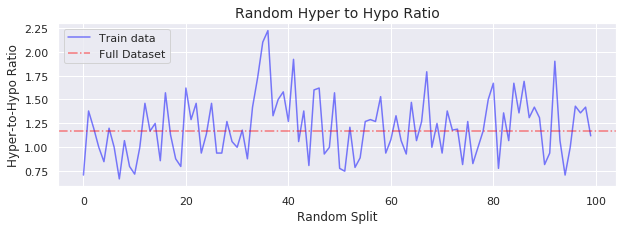

In [9]:
plt.figure(figsize = (10,3))
plt.plot(range(0,100), ratios, color='blue', alpha=0.5, label='Train data')
plt.axhline(hyper_to_hypo_ratio, 0, 1, color="red", label="Full Dataset", alpha = 0.5, linestyle = '-.')
plt.xlabel('Random Split')
plt.ylabel('Hyper-to-Hypo Ratio')
plt.legend(loc='best')
plt.title('Random Hyper to Hypo Ratio', fontsize=14)
print("")

**The hyper-to-hypo ratio varries with each random split. It rarely matches the hyper-to-hypo ratio in the full data set. Any training or test sets built this way would either have more patients with hyperthyroidism or hypothyroidism than it is really the case. The apriori probability for a patient to have either of the disease conditions would be slightly wrong. Classification would be impacted especially if the model tends to choose a majority class.**


**1.3** Now, we'll use the `stratify` option to split the data in such a way that the relative class frequencies are preserved. Make a table showing how many observations of each class ended up in the training and test sets. Verify that the hyper-hypo ratio is roughly the same in both sets.

In [10]:
data_train, data_test = train_test_split(df_thyroid, test_size=.5, stratify=df_thyroid.Diagnosis, random_state=99);

In [11]:
predictor_1 = 'Biomarker 1'
predictor_2 = 'Biomarker 2'
predictors = [predictor_1, predictor_2]
response = 'Diagnosis'
X_train = data_train.loc[:, predictors]
y_train = data_train[response]
X_test = data_test.loc[:, predictors]
y_test = data_test[response]

**We standardize our data to prepare it for regularization and KNN. We do not choose min-max scaler, because it is less robust and we want to avoid the negative impact of huge outliers on the remaining data.**

In [12]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
data_train_scaled = data_train.copy()
data_train_scaled[predictors] = scaler.transform(data_train[predictors])

In [13]:
display_class_distribution(data_train, 'Class distribution in training set')


Class,Patients count
Class 1 - Normal,75
Class 2 - Hyperthyroidism,17
Class 3 - Hypothyroidism,15


In [14]:
display_class_distribution(data_test, 'Class distribution in test set')

Class,Patients count
Class 1 - Normal,75
Class 2 - Hyperthyroidism,18
Class 3 - Hypothyroidism,15


**The hyper-to-hypo ratio is 1.13 in the training set, 1.2 in the test set and 1.17 in the full set. The ratio is roughly the same overall. There is only 1 hyperthyroidism case more in the test set.  This is due to an odd number of patients in the data set.**

**1.4** Provide the scatterplot of the predictors in the (training) data in a way that clearly indicates which class each observation belongs to.

In [15]:
# this function will be used throughout the notebook to scatter plot the data
def plot_data(df, ax, title, colors_set=['r','g','b']):
    for cl in class_names:
        ax.scatter(df[df[response] == cl][predictors[0]], df[df[response] == cl][predictors[1]], color=colors_set[cl-1], alpha=0.6, s=30, label=class_names[cl])
    ax.set_xlabel(predictors[0])
    ax.set_ylabel(predictors[1])
    ax.set_title(title, fontsize=12)
    ax.legend(loc=4)
    ax.grid(False)
    ax.set_facecolor('w')

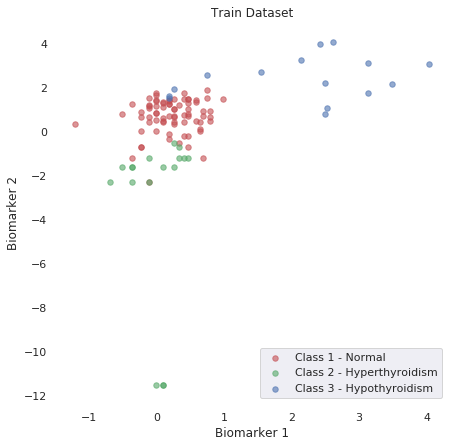

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plot_data(data_train, ax, 'Train Dataset')
plt.grid()
plt.show()

**There is a substantial overlap between class 1 and 2, but also between class 1 and class 3. This makes it difficult to separate those pairs using a single line or even shapes. Classifying one would be at the expense of the classifying the other one.**

**Class 1 points are clustered in the same region with few points far from the center. The total training sample size for that class is not that big, so we cannot say for sure the distribution is normal. Maybe if we plot all the data we might confirm normality. There is no obvious rotation visible, we would rather not expect covariance between Biomarker 1 and 2 within class 1. **

**Class 2 looks like it would be multivariate normal with a rotation that suggests covariance between both features.**

**Class 3 on the order hand shows few clumps of data. We can say for sure that this data is normal. This would matter if we use Linear/Quadratic Discriminant Analysis. It seems that the data is rotated due to some covariance between both features for this class.**

**1.5**: When we first start working with a dataset or algorithm, it's typically a good idea to figure out what *baselines* we might compare our results to. For regression, we always compared against a baseline of predicting the mean (in computing $R^2$). For classification, a simple baseline is always predicting the *most common class*. What "baseline" accuracy can we achieve on the thyroid classification problem by always predicting the most common class? 

In [17]:
most_common_class_train = int(data_train[response].mode())
baseline_accuracy = round(data_train[data_train[response] == most_common_class_train].shape[0]/data_train.shape[0],2)
display(HTML("By predicting the most common class found in the training set ({}), we would obtain the following baseline accuracy on training set: {}".format(class_names[most_common_class_train], baseline_accuracy)))


**1.6** Make a decision function to separate these samples using no library functions; just write out the logic by hand. The manual classifier doesn't need to be well-tuned; it only needs to (1) predict each class at least once, and (2) achieve an accuracy at least 10% greater accurate than predicting the most likely class. Use the `overlay_decision_boundaries` function to overlay the decision boundaries of the function on the training set.

Based on the exploration, do we think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? Could a non-linear classifier do better? What characteristics of the data lead we to these conclusions?

In [18]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['green'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

**Our classifier was designed by observing the scatter plot of training dataset. It classifies samples with Biomarker 1 greater than 1.5 as hypothyroidism. The remaining samples are classified using Biomarker 2, so that values below 0 are considered as hyperthyroidism and as normal otherwise.**

In [19]:
class myClassifier:
    @staticmethod
    def predict(X):
        nX = X.shape[0]
        y = np.zeros(nX)
        for i in range(0, nX):
            if X[i][0] > 1.5:
                y[i] = 3
            elif X[i][1] > 0:
                y[i] = 1
            else:
                y[i] = 2
        return y.astype(int)

In [20]:
def predict_manual_one_sample(x):
    return myClassifier.predict(x.reshape(1, -1))

**For example our classifier considers a sample with Biomarker 1 value 0.5 and Biomarker 2 value -2 as hyhyperthyroism (class 2). **

In [21]:
predict_manual_one_sample(np.array([0.5, -2]))

array([2])

In [22]:
def predict_manual(X):
    return np.array([predict_manual_one_sample(x) for x in X])


In [23]:
manual_predictions = predict_manual(X_train.values)
accuracy = accuracy_score(y_train, manual_predictions)
print("Accuracy of the manual classifier on training dataset:", accuracy)

Accuracy of the manual classifier on training dataset: 0.8598130841121495


In [24]:
assert accuracy >= (baseline_accuracy * 1.10), "Accuracy too low"
assert all(np.sum(manual_predictions == i) > 0 for i in [1, 2, 3]), "Should predict each class at least once."

In [25]:
#this function will be used throughout the notebook for plotting data with decision boundaries overlay
def plot_data_with_decision_boundary(df, model, title, ax=None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    plot_data(df, ax, title)
    overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5)
    

**We plot the training dataset overlayed with decision boundaries provided by our manual classifier.**

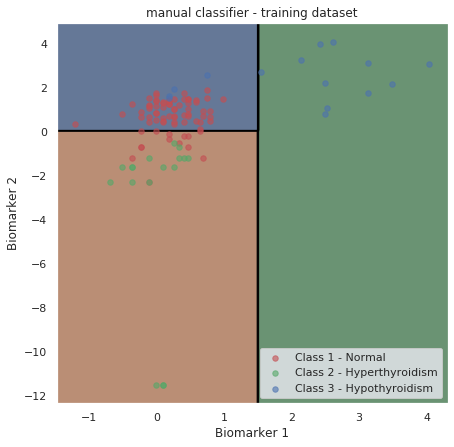

In [26]:
plot_data_with_decision_boundary(data_train, myClassifier, 'manual classifier - training dataset')

By adjusting the threshold for Biomarker 2 after looking at the decision boundaries overlay for train data, we can obtain an accuracy of 85.98% on train data. Using just lines it is hard to draw a boundary between hyperthyroidism and normal cases. It seems that a curve would do a better job in splitting those two groups.  

## Part 2: Multiclass Logistic Regression

**2.1** Fit two one-vs-rest logistic regression models using sklearn. For the first model, use the train dataset as-is (so the decision boundaries will be linear); for the second model, also include quadratic and interaction terms. For both models, use $L_2$ regularization, tuning the regularization parameter using 5-fold cross-validation. 

For each model, make a plot of the training data with the decision boundaries overlayed.

**We now fit a linear logistic regression model with regularization. The L2 tuning parameter is found via crossvalidation.**

**Because of regularization, and because of the difference in values range for Biomarker 1 and 2, as well as for comparison reasons we will be investigating all models in this project on both scaled and unscaled data. **

**Linear Logistic Regression fit on *scaled* training dataset**

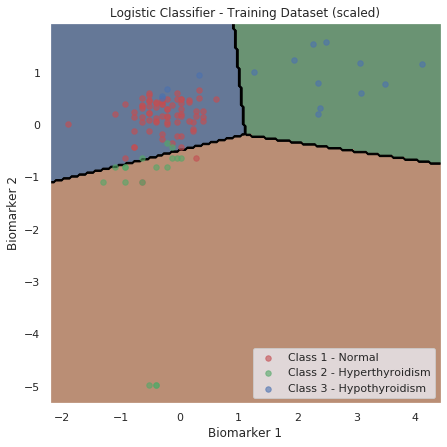

In [27]:
lrm_ov_scaled = LogisticRegressionCV(multi_class = 'ovr', cv=5, penalty='l2').fit(X_train_scaled, y_train)
plot_data_with_decision_boundary(data_train_scaled, lrm_ov_scaled, 'Logistic Classifier - Training Dataset (scaled)')

**Linear Logistic Regression fit on *unscaled* training dataset**

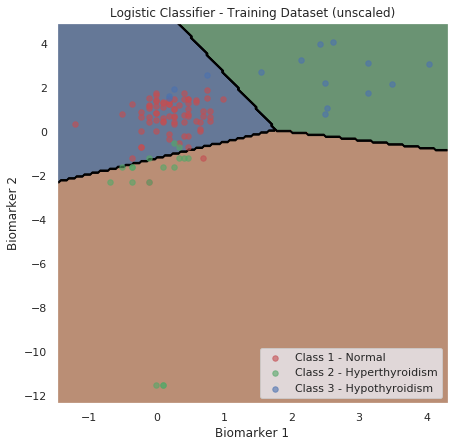

In [28]:
lrm_ov = LogisticRegressionCV(multi_class = 'ovr', cv=5, penalty='l2').fit(X_train, y_train)
plot_data_with_decision_boundary(data_train, lrm_ov, 'Logistic Classifier - Training Dataset (unscaled)')

**As expected, when the data is not scaled, regularization seems to shrinkage coefficients related to the class 2 where the variance is considerably high compared to the other classes. The decision boundaries show a larger area for class 2 when the data is not scaled.**

**Quadratic Logistic Regression fit on *scaled* training dataset**

In [29]:
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="ovr", cv = 5, penalty = 'l2'))

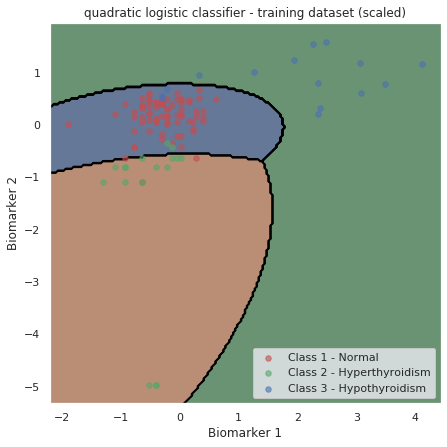

In [30]:
lrm_ov_poly_scaled = polynomial_logreg_estimator.fit(X_train_scaled, y_train)
plot_data_with_decision_boundary(data_train_scaled, lrm_ov_poly_scaled, 'quadratic logistic classifier - training dataset (scaled)')

**Quadratic Logistic Regression fit on *unscaled* training dataset**

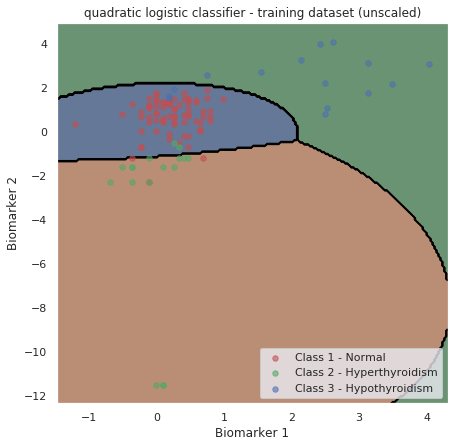

In [31]:
lrm_ov_poly = polynomial_logreg_estimator.fit(X_train, y_train)
plot_data_with_decision_boundary(data_train, lrm_ov_poly, 'quadratic logistic classifier - training dataset (unscaled)')

**Adding quadratic polynomial features and interaction terms helps us dealing with the covariance between features within the class 2. This results in better decision boundaries for that class, compared to the linear logistic model. Scaling the data further adjusts the region for class 2, which is otherwise affected by the two outliers.**

**2.2** Interpret the decision boundaries:
- Do these decision boundaries make sense?
- What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?
- How do the different models treat regions where there are few samples? How do they classify such samples?


- The decision boundaries provided by the logistic regression model make sense, especially when distinguishing between patients with hyperthyroidism and healthy patients. 

- Quadratic and interaction features change the boundaries from lines to curves due to the presence of quadratic terms. QDA serves as a compromise between the non-parametric KNN method and the linear LDA and logistic regression approaches. Since QDA assumes a quadratic decision boundary, it can accurately model a wider range of problems than can the linear methods. QDA can perform better in the presence of a limited number of training observations because it does make some assumptions about the form of the decision boundary.

- The model treats regions where there are few regions, somewhat similar to a KNN classifier where their class resembles that of their nearest neighbors.

**2.3** Compare the performance of the two logistic regression models above using 5-fold cross-validation. Which model performs best? How confident are we about this conclusion? Does the inclusion of the polynomial terms in logistic regression yield better accuracy compared to the model with only linear terms? Why do we suspect it is better or worse?

The cross-validation scores obtained with each of the models are summarized below.

In [32]:
lrm_cv_scores = dict()
lrm_cv_scores['Linear logistic regression (unscaled)'] = cross_val_score(lrm_ov, X_train, y_train, cv=5, scoring='accuracy')
lrm_cv_scores['Linear logistic regression (scaled)'] = cross_val_score(lrm_ov_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')
lrm_cv_scores['Quadratic logistic regression (unscaled)'] = cross_val_score(lrm_ov_poly, X_train, y_train, cv=5, scoring='accuracy')
lrm_cv_scores['Quadratic logistic regression (scaled)'] = cross_val_score(lrm_ov_poly_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')
lrm_cv_scores_df = pd.DataFrame(lrm_cv_scores)
lrm_cv_scores_df

,Linear logistic regression (unscaled),Linear logistic regression (scaled),Quadratic logistic regression (unscaled),Quadratic logistic regression (scaled)
0,0.863636,0.863636,0.909091,0.909091
1,0.863636,0.863636,0.863636,0.863636
2,0.952381,0.904762,0.904762,0.904762
3,0.952381,0.952381,0.904762,0.857143
4,0.904762,0.904762,0.952381,0.952381


In [33]:
lrm_cv_scores_df.describe()

,Linear logistic regression (unscaled),Linear logistic regression (scaled),Quadratic logistic regression (unscaled),Quadratic logistic regression (scaled)
count,5.000000,5.000000,5.000000,5.000000
mean,0.907359,0.897835,0.906926,0.897403
std,0.044396,0.036777,0.031441,0.038647
min,0.863636,0.863636,0.863636,0.857143
25%,0.863636,0.863636,0.904762,0.863636
50%,0.904762,0.904762,0.904762,0.904762
75%,0.952381,0.904762,0.909091,0.909091
max,0.952381,0.952381,0.952381,0.952381


The 95% confidence intervals of the cross-validation scores are given as follows.

In [34]:
import statsmodels.stats.api as sms

sms.DescrStatsW(lrm_cv_scores_df).tconfint_mean()

(array([0.85223434, 0.85217028, 0.86788699, 0.84941585]),
 array([0.96248428, 0.94350071, 0.94596583, 0.94538934]))

** The linear logistic regression classifier provides the best average cross-validation performance, however with a wider confidence interval. Scaling data does not affect the performance.**

**The inclusion of polynomial terms does not hield better results on training, but we might expect this model to perform better on test.**


---






## Part 3: Discriminant Analysis

**3.1** Consider the following synthetic dataset with two classes. A green star marks a test observation; which class do we think it belongs to? How would LDA classify that observation? How would QDA? Explain the reasoning.

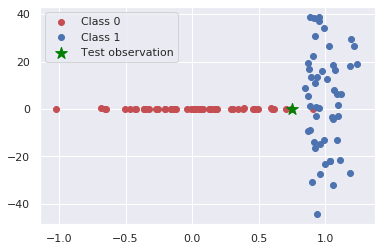

In [35]:
X_blobs, y_blobs = make_blobs(centers=[[0., 0.], [1., 0.]], cluster_std=[[.4, .1], [.1, 20.]], random_state=0)
plt.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0", color = 'r')
plt.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
plt.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
plt.legend();

In [36]:
np.var(X_blobs[y_blobs==0][:,1]), np.var(X_blobs[y_blobs==1][:,1])

(0.009677268278481746, 437.1360123184156)

**We can see here that the variance for Class 0 is almost 0 -- borderline negligible while the variance for Class 1 is 437. **

**LDA would draw the boundary at  𝑥=(𝜇1+𝜇2)/2≈0.5 . Therefore the green star would be classified as class 1. Since QDA uses a covariance matrix for each class, the high variance in class 1 would lead into curving the boundary. Therefore the green star would most probably be classified as class 0. LDA’s assumption that both classes share a common covariance matrix is badly off in this case.**

---



In [37]:
np.mean(X_blobs[y_blobs==0][:,1]), np.mean(X_blobs[y_blobs==1][:,1])

(0.010280986769162084, 3.6549493696432402)

In [38]:
np.cov(X_blobs[y_blobs==0].T), np.cov(X_blobs[y_blobs==1].T)

(array([[ 0.17309846, -0.00135899],
        [-0.00135899,  0.00987476]]),
 array([[ 1.04891498e-02, -3.08678192e-02],
        [-3.08678192e-02,  4.46057155e+02]]))

In [39]:
#fitting our data to LDA and QDa 
lda_blob = LinearDiscriminantAnalysis()
lda_blob.fit(X_blobs, y_blobs)
qda_blob = QuadraticDiscriminantAnalysis()
qda_blob.fit(X_blobs, y_blobs)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

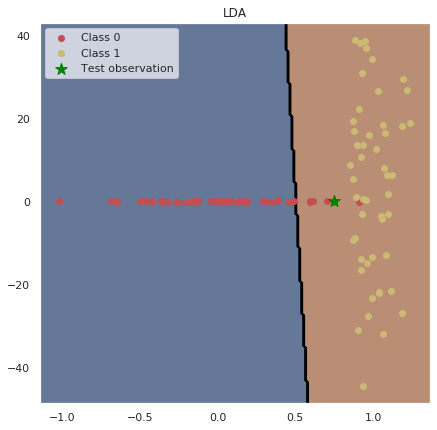

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0", color = 'r')
ax.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1", color = 'y')
ax.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
ax.set_title('LDA')
ax.legend();
overlay_decision_boundary(ax, lda_blob, colors=None, nx=200, ny=200, desaturate=.5)

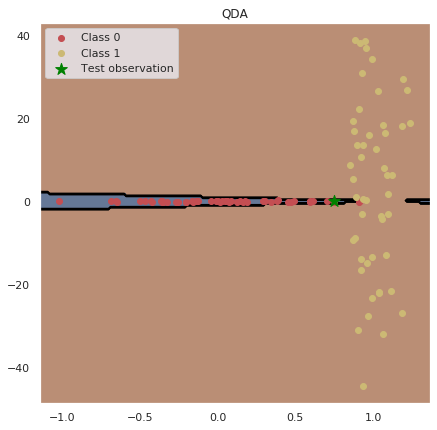

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0", color ='r')
ax.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1", color = 'y')
ax.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
ax.set_title('QDA')
ax.legend();
overlay_decision_boundary(ax, qda_blob, colors=None, nx=200, ny=200, desaturate=.5)

In [42]:
def print_var_cov(data):
    html = '<h4></h4><table><tr><td><b>Class</b></td><td><b>Var ' + predictors[0] 
    html += '</b></td><td><b>Var ' + predictors[1] 
    html += '</b></td><td><b>Covariance</b></td></tr>'
    for cl in class_names:
        html += '<tr><td>'+ class_names[cl]+'</td><td>'
        html += str(round(np.var(data[data[response]==cl][predictors[0]]),3)) + '</td><td>' 
        html += str(round(np.var(data[data[response]==cl][predictors[1]]),3)) + '</td><td>'
        html += str(round(data[data[response]==cl].cov()[predictors[0]][predictors[1]],3)) + '</td></tr>'
    html += '<tr><td>full dataset</td><td>'
    html += str(round(np.var(data[predictors[0]]),3)) + '</td><td>' 
    html += str(round(np.var(data[predictors[1]]),3)) + '</td><td>'
    html += str(round(data.cov()[predictors[0]][predictors[1]],3)) + '</td></tr></table>'
    display(HTML(html))

In [43]:
print_var_cov(data_train)

Class,Var Biomarker 1,Var Biomarker 2,Covariance
Class 1 - Normal,0.132,0.599,0.039
Class 2 - Hyperthyroidism,0.113,14.809,-0.016
Class 3 - Hypothyroidism,1.435,0.899,0.346
full dataset,0.761,5.63,0.749


**3.3** Fit LDA and QDA on the thyroid data, and plot the decision boundaries. Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table we computed above?


**Linear Discriminant Analysis on *scaled* training dataset**

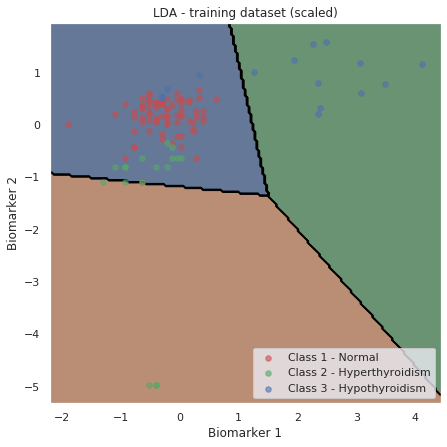

In [44]:
lda_scaled = LinearDiscriminantAnalysis()
lda_scaled.fit(X_train_scaled, y_train)
plot_data_with_decision_boundary(data_train_scaled, lda_scaled, 'LDA - training dataset (scaled)')

**Linear Discriminant Analysis on *unscaled* training dataset**

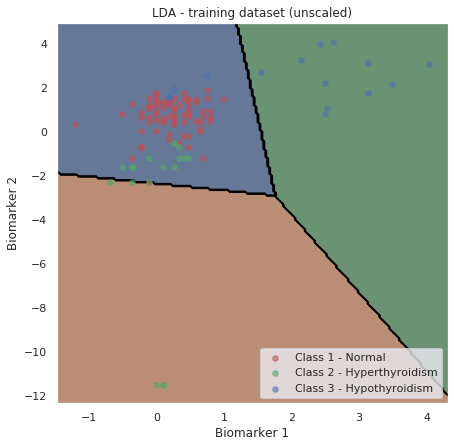

In [45]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
plot_data_with_decision_boundary(data_train, lda, 'LDA - training dataset (unscaled)')

**Quadratic Discriminant Analysis on *scaled* training dataset**

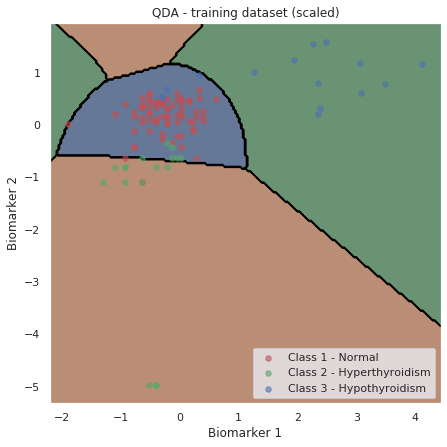

In [46]:
qda_scaled = QuadraticDiscriminantAnalysis()
qda_scaled.fit(X_train_scaled, y_train)
plot_data_with_decision_boundary(data_train_scaled, qda_scaled, 'QDA - training dataset (scaled)')

**Quadratic Discriminant Analysis on *unscaled* training dataset**

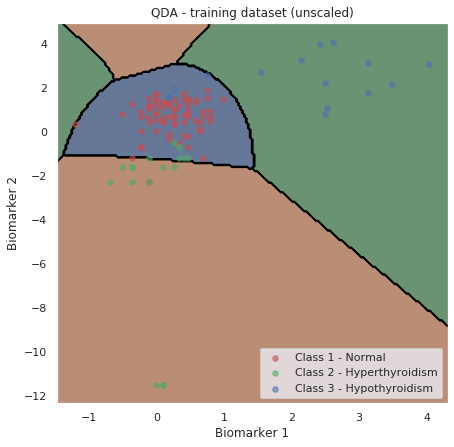

In [47]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
plot_data_with_decision_boundary(data_train, qda, 'QDA - training dataset (unscaled)')

**LDA decision boundaries are straight lines, while QDA boundaries are curves. LDA is similar to Logistic since it models the probability (Gaussian) of predictors given the class, which behaves similar to direct logistic probability calculation thanks to the Bayes theorem, what is not the case on the training set.**

**LDA missclassifies almost all samples in the hyperthyroidism class. This is due to the high variance (14.809) in class 2 for Biomarker 2. LDA suffers from high biais here following its assumption that all three classes share a common covariance matrix. **

**QDA takes the difference in variance among classes into consideration. It  models quadratic functions of biomarkers and gives quadratic decision surfaces. **

**In contrast to Logistic regression, LDA and QDA allows us to change the prior fraction of individuals in each class while fitting on training data. This would allows us to adjust the weight of the dominant class 1 (70% on train) in order to achieve better prediction , assuming that the class proportions will be similar on test and we will not experience any covariance shift there.**

**Scaling data does not appear to affect the classification boundaries for LDA and QDA so much**

## Part 4: Fit Decision Trees 


We next try out decision trees for thyroid classification. For the following questions, we should use the *Gini* index as the splitting criterion while fitting the decision tree. 

**4.1**. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the accuracy as a function of the maximum tree depth, on the training set and the mean score on the validation sets for 5-fold CV. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can we say about how this tree will generalize? Which hyperparameter setting gives the best cross-validation performance?

**Helper functions**

In [48]:
# function to plot cross-validation scores and accuracy changes for a range of hyper-parameters values
def plot_cv_scores(hyper_params, accuracy, cv_score, xlabel, title):
  plt.figure(figsize = (10,3))
  plt.plot(hyper_params, accuracy, color='blue', alpha=0.5, label='Training accuracy')
  plt.plot(hyper_params, cv_score, color='red', alpha=0.5, label='Cross-validation performance')
  plt.xlabel(xlabel)
  plt.ylabel('score')
  plt.legend(loc='best')
  plt.title(title, fontsize=14)
  print("")

In [49]:
# function to run cross-validation on a set of decision trees by varying the depth within a given range
def cross_validation_on_tree(X, y, tree_depths):
  dtc_accuracy = []
  dtc_cv_score = []
  for depth in tree_depths:
      dtc = DecisionTreeClassifier(max_depth=depth, criterion='gini')
      dtc.fit(X, y)
      dtc_accuracy.append(dtc.score(X, y))
      dtc_cv_score.append(np.mean(cross_val_score(dtc, X, y, cv=5)))
  return dtc_accuracy, dtc_cv_score

In [50]:
# function for displaying the best cross-validation score and the corresponding hyper-parameter value
def display_best_hyper_param(param_vals, cv_scores, hyper_param_label, data_label):
  best_cv_score = max(cv_scores)
  best_cv_score_rounded = round(best_cv_score,5)
  best_param = param_vals[cv_scores.index(best_cv_score)]
  display(HTML("Best cross-validation score {} obtained with {}={} on {}<br><br>".format(best_cv_score_rounded, hyper_param_label, best_param, data_label)))
  return best_cv_score_rounded, best_param

In [51]:
# main function for running cross-validation, plotting scores and displaying selected parameter
def fit_decision_tree_with_cv(X, y, title, tree_depths=range(1, 11)):
  display(HTML('<h4>{}</h4>'.format(title)))
  dtc_accuracy, dtc_cv_score = cross_validation_on_tree(X, y, tree_depths)
  plot_cv_scores(tree_depths, dtc_accuracy, dtc_cv_score, 'tree depth', 'Accuracy by Tree Depth on {}'.format(title))
  dtc_cv_score_best, best_tree_depth = display_best_hyper_param(tree_depths, dtc_cv_score, 'Tree Depth', title)
  return dtc_cv_score_best, best_tree_depth 

We fit a set of decision trees using scaled and unscaled data.

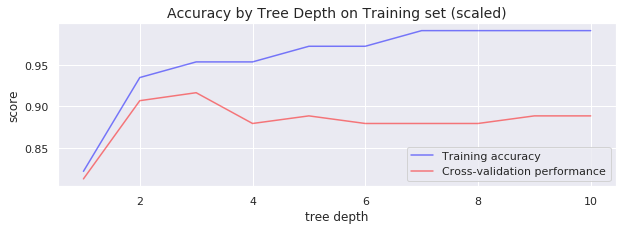

In [52]:
dtc_cv_score_best_scaled, best_tree_depth_scaled  = fit_decision_tree_with_cv(X_train_scaled, y_train, 'Training set (scaled)')

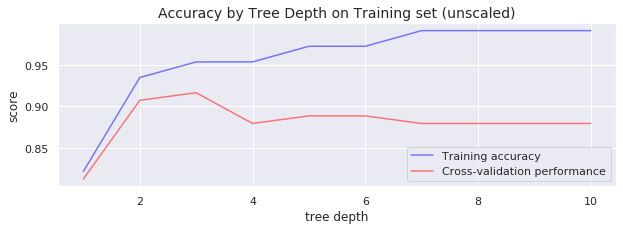

In [53]:
dtc_cv_score_best, best_tree_depth  = fit_decision_tree_with_cv(X_train, y_train, 'Training set (unscaled)')

**A decision tree of depth 7 achieves near-perfect classification on training set. This tree is most probably overfitting to the training set and will not generalize well on test set.**

**A tree of depth 3 gives the best cross-validation performance what is a good sign of generalization on test.**

**Scaling data has no effect on cross-validation performance and accuracy.**

**4.2**: Visualize the decision boundaries of the best decision tree we just fit. How are the shapes of the decision boundaries for this model different from the other methods we have seen so far? Given an explanation for the observation.

We display the decision boundaries obtained with decision trees using the best depth obtained via cross-validation.

In [54]:
dtc_scaled = DecisionTreeClassifier(max_depth=best_tree_depth_scaled, criterion='gini')
dtc_scaled.fit(X_train_scaled, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

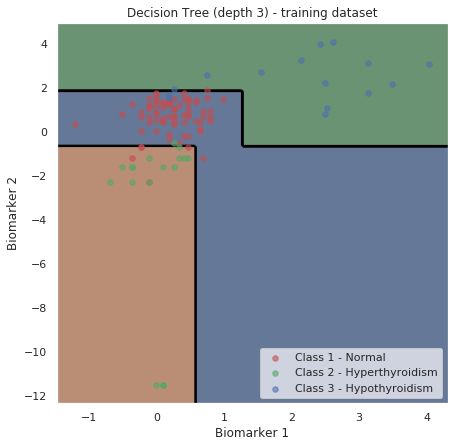

In [55]:
dtc = DecisionTreeClassifier(max_depth=best_tree_depth, criterion='gini')
dtc.fit(X_train, y_train)
plot_data_with_decision_boundary(data_train, dtc, 'Decision Tree (depth {}) - training dataset'.format(best_tree_depth))

**The classification boundaries produced by the decision tree have rectangular shapes. Logistic, LDA and QDA regression models had lines and curves shapes, but not rectangular shapes. **

**Decision Trees divide the predictors space using threshold values of one predictor at a time. This results in drawing vertical and horizontal lines, which divide the space into three non-overlapping regions.**

**Here the true decision boundary is non-linear. A linear model is unable to capture the true decision boundary , whereas a decision tree is successful as it is able to split the boundaries in a well-defined manner.**

**4.3** Explain *in words* how the best fitted model diagnoses 'hypothyroidism' for a new patient. We need to examine the structure of the best decision tree.

We can also generate a visual representation using the `export_graphviz`. However, viewing the generated GraphViz file requires additional steps. One approach is to paste the generated graphviz file in the text box at http://www.webgraphviz.com/. Alternatively, we can run GraphViz on the own computer, but we may need to install some additional software. Refer to the [Decision Tree section of the sklearn user guide](http://scikit-learn.org/stable/modules/tree.html#classification) for more information.

In [56]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [57]:
show_tree_structure(dtc)

The binary tree structure has 11 nodes:

node 0: if X[:, 1] <= -0.693 then go to node 1, else go to node 6
  node 1: if X[:, 0] <= 0.582 then go to node 2, else go to node 5
    node 2: if X[:, 0] <= -0.053 then go to node 3, else go to node 4
      node 3: predict class 2
      node 4: predict class 2
    node 5: predict class 1
  node 6: if X[:, 0] <= 1.270 then go to node 7, else go to node 10
    node 7: if X[:, 1] <= 1.879 then go to node 8, else go to node 9
      node 8: predict class 1
      node 9: predict class 3
    node 10: predict class 3


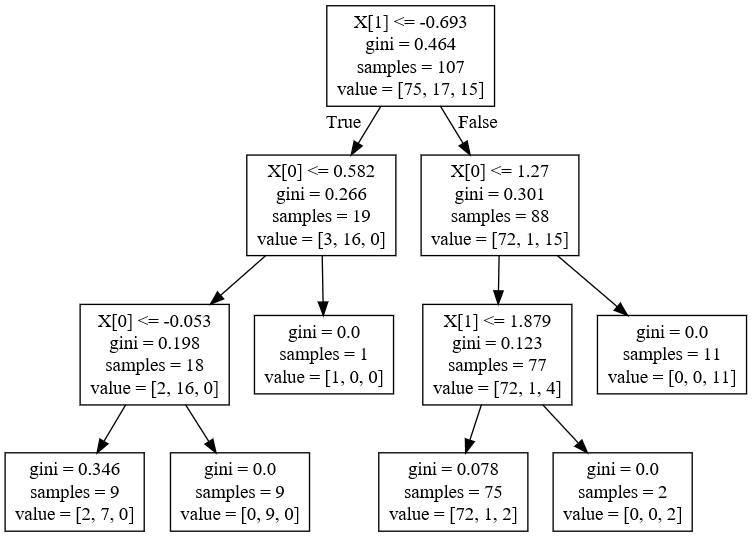

In [58]:
dot_data = export_graphviz(dtc, out_file=None) 
from IPython.display import Image
# the tree image was generated on http://www.webgraphviz.com/
Image('data/tree.png')

For a new patient, Hypothyroidism (class 3) is diagnosed by the fitted tree as follows:

* **step 1** - check Biomarker 2. If the value is less than -0.693, then patient is Hypothyroidism negative. Otherwise proceed with step 2.
* **step 2** - check Biomarker 2. If the value is greater than 1.879, then patient is Hypothyroidism positive. Otherwise proceed with step 3.
* **step 2** - check Biomarker 1. If the value is greater than 1.270, then patient is Hypothyroidism positive. Otherwise patient is Hypothyroidism negative.  

## Part 5: k-NN and Model comparison

We have now seen six different ways of fitting a classification model: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **decision trees**, and in this problem we'll add **k-NN**. Which of these methods should we use in practice for this problem? To answer this question, we now compare and contrast these methods.

**5.1** Fit a k-NN classifier with uniform weighting to the training set. Use 5-fold CV to pick the best $k$.

**Helper functions**

In [59]:
# fit a KNN classifier using a range of values for k and return cross-validation scores for each
def cross_validation_on_knn(X, y, k_list):
  knn_cv_scores = []
  knn_accuracy = []
  for k in k_list:
      knn = KNeighborsClassifier(n_neighbors=k)
      knn_accuracy.append(knn.fit(X, y).score(X, y))
      knn_cv_scores.append(np.mean(cross_val_score(knn, X, y, cv=5, scoring='accuracy')))  
  return knn_accuracy, knn_cv_scores

In [60]:
# perform cross-validation and display the best KNN model
def fit_knn_with_cv(X, y, title, k_list=range(1, 50)):
  display(HTML('<h4>{}</h4>'.format(title)))
  knn_accuracy, knn_cv_score = cross_validation_on_knn(X, y, k_list)
  plot_cv_scores(k_list, knn_accuracy, knn_cv_score, 'neighbors', 'Accuracy by k-neighbors on {}'.format(title))
  knn_cv_scores_best, best_k = display_best_hyper_param(k_list, knn_cv_score, 'neighbors', title)
  return knn_cv_scores_best, best_k 

**KNN on *scaled* training dataset**

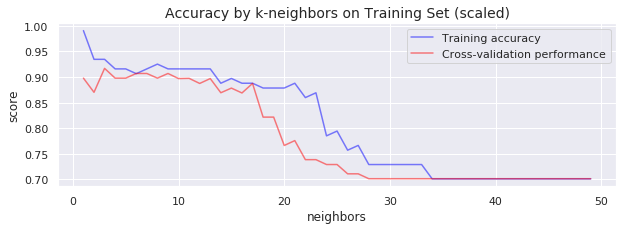

In [61]:
knn_cv_score_best_scaled, best_k_scaled  = fit_knn_with_cv(X_train_scaled, y_train, 'Training Set (scaled)')

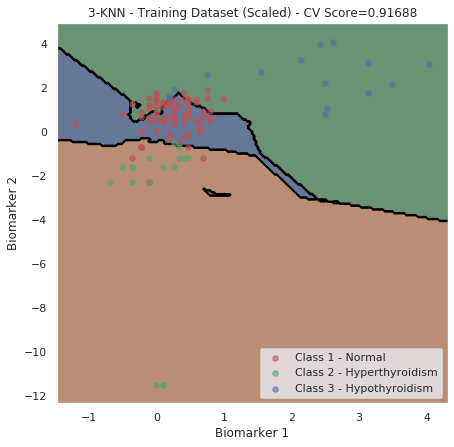

In [62]:
knn_scaled = KNeighborsClassifier(n_neighbors=best_k_scaled)
knn_scaled.fit(X_train_scaled, y_train)
plot_data_with_decision_boundary(data_train, knn_scaled, '{}-KNN - Training Dataset (Scaled) - CV Score={}'.format(best_k_scaled, knn_cv_score_best_scaled))

**KNN on *unscaled* training dataset**

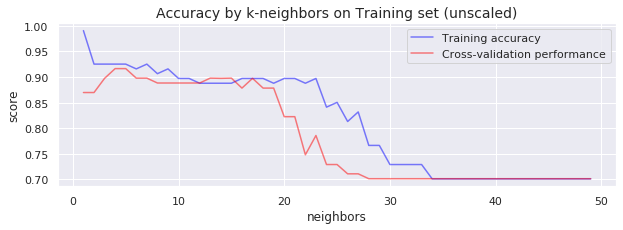

In [63]:
knn_cv_score_best, best_k  = fit_knn_with_cv(X_train, y_train, 'Training set (unscaled)')

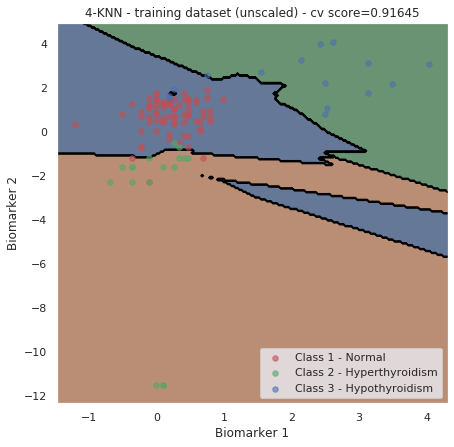

In [64]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
plot_data_with_decision_boundary(data_train, knn, '{}-KNN - training dataset (unscaled) - cv score={}'.format(best_k,knn_cv_score_best))

**5.2** Plot the decision boundaries for each of the following models that we fit above. For models with hyperparameters, use the values we chose using cross-validation.
- Logistic Regression (linear)
- Logistic Regression (polynomial)
- Linear Discriminant Analysis 
- Quadratic Discriminant Analysis
- Decision Tree
- k-NN

Comment on the difference in the decision boundaries between the following pairs of models. Why does this difference make sense given how the model works?
- Linear logistic regression; LDA
- Quadratic logistic regression; QDA.
- k-NN and whichever other model has the most complex decision boundaries

Dictionnary for all models studied so far, trained on **scaled** data.

In [65]:
models_scaled = {1:{'name': 'Logistic Regression (linear) scaled', 'model': lrm_ov_scaled, 'cv score': -1, 'accuracy': -1},
          2:{'name': 'Logistic Regression (polynomial) scaled', 'model': lrm_ov_poly_scaled, 'cv score': -1, 'accuracy': -1},
          3:{'name': 'Linear Discriminant Analysis scaled', 'model': lda_scaled, 'cv score': -1, 'accuracy': -1},
          4:{'name': 'Quadratic Discriminant Analysis scaled', 'model': qda_scaled, 'cv score': -1, 'accuracy': -1},
          5:{'name': 'Decision Tree (depth {}) scaled'.format(best_tree_depth), 'model': dtc_scaled, 'cv score': -1, 'accuracy': -1},
          6:{'name': 'k-NN (neighbors={}) scaled'.format(best_k_scaled), 'model': knn_scaled, 'cv score': -1, 'accuracy': -1}
         }

Dictionnary for all models studied so far, trained on **unscaled** data.

In [66]:
models = {1:{'name': 'Logistic Regression (linear)', 'model': lrm_ov, 'cv score': -1, 'accuracy': -1},
          2:{'name': 'Logistic Regression (polynomial)', 'model': lrm_ov_poly, 'cv score': -1, 'accuracy': -1},
          3:{'name': 'Linear Discriminant Analysis', 'model': lda, 'cv score': -1, 'accuracy': -1},
          4:{'name': 'Quadratic Discriminant Analysis', 'model': qda, 'cv score': -1, 'accuracy': -1},
          5:{'name': 'Decision Tree (depth {})'.format(best_tree_depth), 'model': dtc, 'cv score': -1, 'accuracy': -1},
          6:{'name': 'k-NN (neighbors={})'.format(best_k), 'model': knn, 'cv score': -1, 'accuracy': -1}
         }

**Helper function**

In [67]:
# Displays decision boundaries for a bunch of models next to each other for vizual comparison
def benchmark_decision_boundary(models, data):
    nrows = len(models)//3
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(20,10))
    i = 0
    for m in models:
        title = models[m]['name']
        if models[m]['cv score'] != -1:
          title += ' - cv score {}'.format(models[m]['cv score'])
        if models[m]['accuracy'] != -1:
          title += ' - test accuracy {}'.format(models[m]['accuracy'])
         
        plot_data_with_decision_boundary(data, models[m]['model'], title, ax[i%nrows][i%ncols])
        i += 1

**Benchmark of decision boundaries for models fit with *scaled* data**

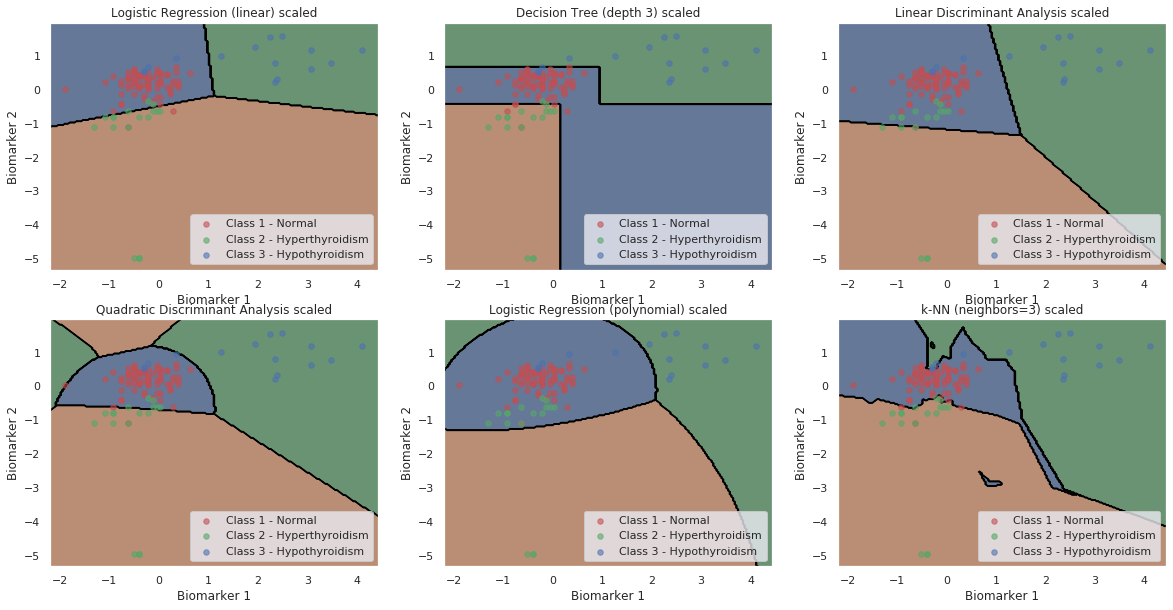

In [68]:
benchmark_decision_boundary(models_scaled, data_train_scaled)

**Benchmark of decision boundaries for models fit with *unscaled* data**

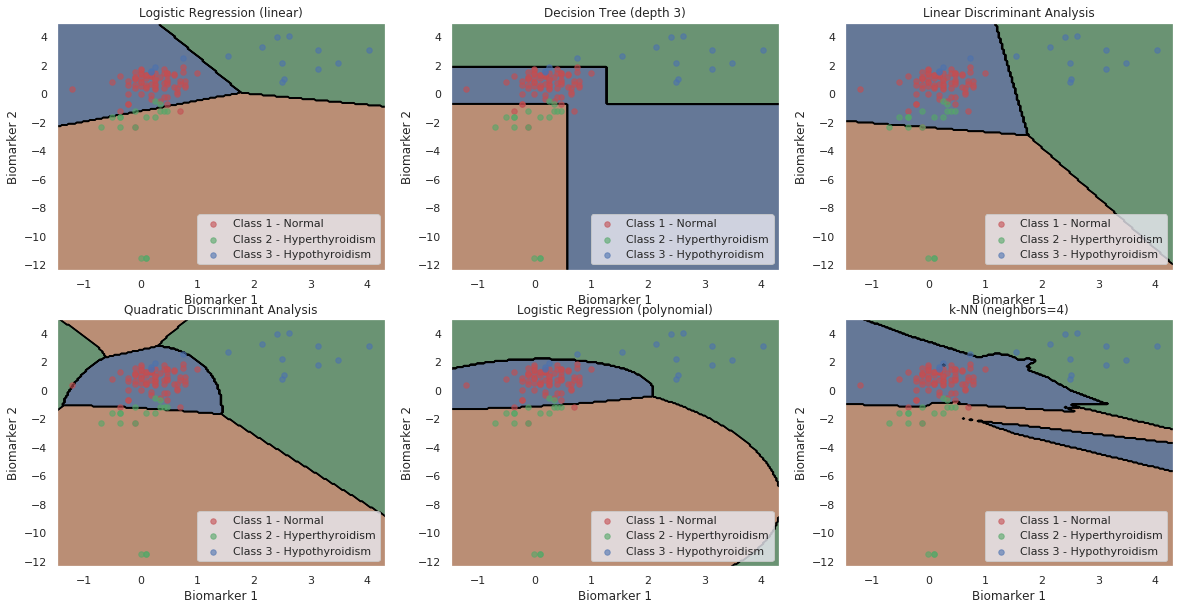

In [69]:
benchmark_decision_boundary(models, data_train)



*   The linear logistic regression models the probability of each sample belonging to either class 1, 2 or 3. It assigns the sample to the class where the probability if the highest. The probability is calculated by maximizing the likelihood function. This results in a larger area for class 2. That area is smaller for LDA that works the other way around by modeling the PDF of samples within each class. LDA takes apriori class probability into account while assuming equal covariance among classes, this has the effect of assigning class 2 samples to the region 1. It seems that a class 1 sample that is found exactely at the same position as a class 2 sample within the class 2 region is causing the boundaries between class 1 and 2 to be pushed down by LDA.
*   QDA and quadratic logistic regression offers shaped boundaries which achieve a better class distinction. Samples for classes 2 and 3 are rotated in the same direction on the scatter plot, this covariance effect appears to be better captured by the decision boundaries for QDA.
* kNN decision boundaries are the most complex and the model appears to overfit. The regions obtained by the decision trees are not that complex, but do miss the flexibility of k-NN.



**Effect of scaling data on decision boundaries**

k-NN: distances are definetely impacted by scaling. The k-NN model trained on scaled data provides needs 1 less neighbor compared to the one trained on unscaled data. The shapes of decision boundaries indicate a higher level of class distinction. 

Decision tree: scaling has no effect on the shape of decision boundaries. This is expected because at each node, the decision made based on the feature value does not depend on the scale change.

LDA, QDA, linear logistic regression: scalling causes very little change in the decision boundaries.

Polynomial logistic regression: scaling data has a very negative impact on separating class 1 from class 2. 



**5.3** Describe how each model classifies an observation from the test set.

* **Linear Logistic regression**: we directly estimate the probability (sigmoids) of having a given class versus the rest using a likelihood function and predict the class for which the probability exceeds 0.5 
* **Polynomial Logistic regression**: we add polynomial terms to the sigmoidal probability functions and proceed similarly to the linear logistic regression.
* **Linear Discriminant Analysis**: given the density function of the predictors, assuming normality and equal variance, we choose the class that maximizes the posterior probability that an observation belongs to a specific class, obtained via Bayes' theorem.
* **Quadratic Discriminant Analysis**: we proceed similarly to the LDA but without the assumption of equal variance between classes.
* **Decision tree**: in the node we ask a specific question about one predictor at a time, this leads down the path to the leaves where the classes (regions) are predicted.
* **k-NN**: we find the k-nearest neighbors of the observation and predict the majority class of those.

**5.4** Estimate the validation accuracy for each of the models. Summarize the results in a graph or table.

**Helper function**

In [70]:
def display_cv_score(models, X, y, title, cv=5):
    html = '<h4>{}</h4><table><tr><td><b>Model</b><td><b>Score</b></td></tr>'.format(title)
    for m in models:
        models[m]['cv score'] = round(np.mean(cross_val_score(models[m]['model'], X, y, scoring='accuracy', cv=cv)),5)
        html += '<tr><td>{}</td><td>{}</td></tr>'.format(models[m]['name'], models[m]['cv score'])
    html += '</table>'
    display(HTML(html))
    return models

In [71]:
models_scaled = display_cv_score(models_scaled, X_train_scaled, y_train, 'Cross-validation scores on training dataset (scaled)', cv=5)

In [72]:
models = display_cv_score(models, X_train, y_train, 'Cross-validation scores on training dataset (unscaled)', cv=5)

**5.5** Based on everything we've found in this project so far, which model would we expect to perform best on our test data? 

Now evaluate each fitted model's performance on the test set. Also, plot the same decision boundaries as above, but now showing the test set. How did the overall performance compare with the performance estimates above? Which model actually performed best? Why do we think this is the case?

**The linear logistic regression provides the best cross-validation accurary of all the models investigates so far. Because the classes are not well separated in the predictors space (see scatter plot), we wouldn't expect it to perform so well on test set. The polynomial version brings more flexible classification boundaries but is more prone to overfit on training set.**

**Linear Discriminant Analysis has the worst cross-validation accuracy. Its quadratic version improves the accuracy. We expect it to deal with the difference of variance among the classes. However Quadratic Discriminant Analysis does not outperform logistic regression.**

**Decision Tree with depth 3 achieves surprisingly the same cross-validation accuracy than k-NN with 4 neighbors on unscaled data. In general k-NN is more prone to overfit to training data and could be less performant on test than expected. With cross-validation and scalling we can however expect it to do pretty well**

**We would choose the Decision Tree (depth 3) with Gini index for their flexibility and interpretability. In this medical context, this model would be accurate for prediction on test set.**



In [73]:
# helper function for displaying test accuracy for all models
def display_test_accuracy(models, X, y, title):
    html = '<h4>{}</h4><table><tr><td><b>Model</b><td><b>Accuracy</b></td></tr>'.format(title)
    for m in models:
        models[m]['accuracy'] = round(models[m]['model'].score(X, y), 5)
        html += '<tr><td>{}</td><td>{}</td></tr>'.format(models[m]['name'], models[m]['accuracy'])
    html += '</table>'
    display(HTML(html))
    return models

In [74]:
models_scaled = display_test_accuracy(models_scaled, X_test_scaled, y_test, 'Classification accuracy on test dataset (scaled)')

In [75]:
models = display_test_accuracy(models, X_test, y_test, 'Classification accuracy on test dataset (unscaled)')

**Suprisingly, Decision Trees did not outperform the remaining models as we predicted. It is Polynomial Logistic Regression that achieves the highest cross-validation accuracy on unscaled test dataset. This is probably because our Decision Tree was too simple enough to avoid overfitting, but did not contained enough nodes to reduce bias. We might consider adding more depth and using pruning to improve the accuracy.**

**Linear logistic regression and linear discriminant analysis provides boundaries made of straight lines, which do not capture the difference in variance between test set and train set. They work well for train set, but perform poorly on test. In essence, Linear Logistic Regression and LDA are closely connected as both are linear functions. One might even expect them to produce similar results, as they sometimes do. Though, it must be noted that for LDA the co-efficents are calculated using the estimated mean and variance from a normal distribution. While the co-efficents for Linear Logistic Regression are calculated using maximum likelihood.**

**k-NN does as good as QDA when we use 4 neighbors with data scaling. **

**Polynomial Linear Regression achieves the best accuracy on test among all the models studied, although its performance on training set was not the best. It appears that this model provides the best variance-biais balance for our data. **

**Scaling our data was not required for achieving better accuracy.**


### Decision boundaries overlay on test dataset

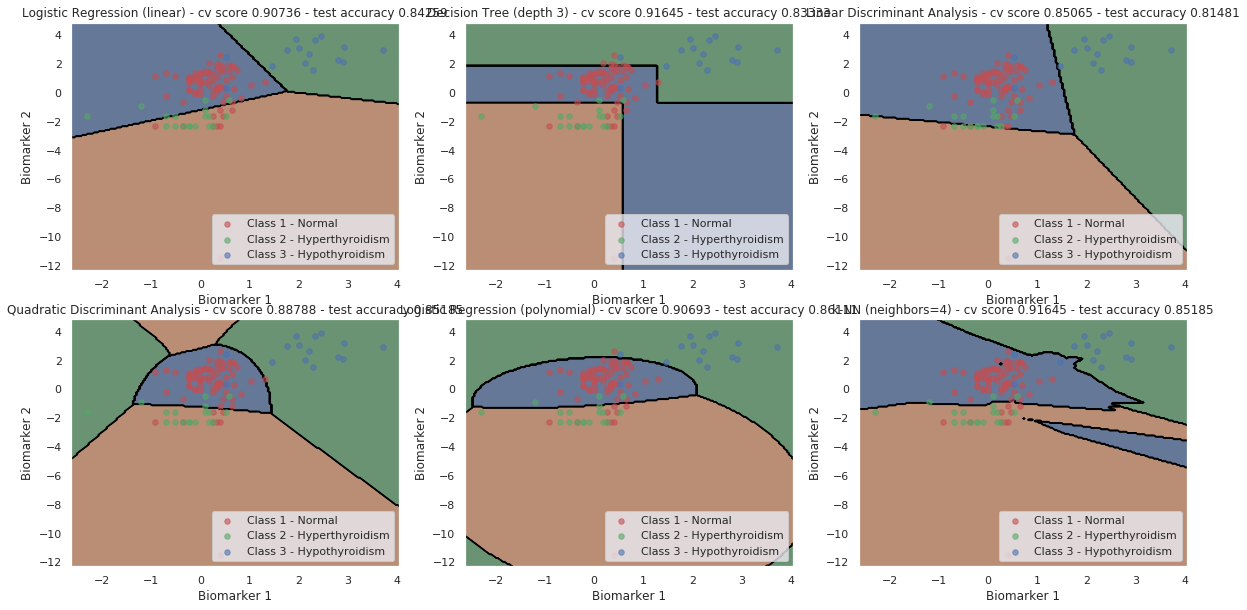

In [76]:
benchmark_decision_boundary(models, data_test)

**5.6**. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize the  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Interpretability

If we were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would we be most comfortable in using? Justify the choice in terms of at least 3 different aspects.

In [77]:

models[1]['performance'] = 'slow - gradient descent likelihood calculation'
models[2]['performance'] = 'slow - gradient descent likelihood calculation'
models[3]['performance'] = 'very fast - PDF, means, var calculation'
models[4]['performance'] = 'fast - PDF, mean, var, covar calculation'
models[5]['performance'] = 'fast - tree travelling'
models[6]['performance'] = 'very slow - distance calculation'

models[1]['complexity'] = 'low - straight lines'
models[2]['complexity'] = 'medium - quadratic lines'
models[3]['complexity'] = 'low - straight lines'
models[4]['complexity'] = 'medium - quadratic lines'
models[5]['complexity'] = 'high - rectangles'
models[6]['complexity'] = 'very high - fuzzy lines and shapes'

models[1]['memory'] = 'low - store coefs (betas) values'
models[2]['memory'] = 'low - store coefs (betas) values'
models[3]['memory'] = 'low - store class means, variances'
models[4]['memory'] = 'low - store class means, variances, covariances'
models[5]['memory'] = 'high - store nodes (decision), edges, leaves'
models[6]['memory'] = 'very high - store the whole training dataset'

models[1]['interpretability'] = 'very high - inference, coefs analysis'
models[2]['interpretability'] = 'very high - inference, coefs analysis'
models[3]['interpretability'] = 'low - purely predictive, apriori probability'
models[4]['interpretability'] = 'low - purely predictive, apriori probability'
models[5]['interpretability'] = 'high - features ranking, good for decisions'
models[6]['interpretability'] = 'low - purely predictive'


html =  '<h3>Final benchmark</h3><table style="align-text: center"><tr>'
html += '<td><b>Model</b></td>'
html += '<td><b>Accuracy</b></td>'
html += '<td><b>Computational performance</b></td>'
html += '<td><b>Complexity of decision boundary</b></td>'
html += '<td><b>Memory storage</b></td>'
html += '<td><b>Interpretability</b></td></tr>'

for m in models:
    html += '<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>'.format(models[m]['name'], models[m]['cv score'], models[m]['performance'], models[m]['complexity'], models[m]['memory'], models[m]['interpretability'])
html += '</table>'

display(HTML(html))


Model,Accuracy,Computational performance,Complexity of decision boundary,Memory storage,Interpretability
Logistic Regression (linear),0.90736,slow - gradient descent likelihood calculation,low - straight lines,low - store coefs (betas) values,"very high - inference, coefs analysis"
Logistic Regression (polynomial),0.90693,slow - gradient descent likelihood calculation,medium - quadratic lines,low - store coefs (betas) values,"very high - inference, coefs analysis"
Linear Discriminant Analysis,0.85065,"very fast - PDF, means, var calculation",low - straight lines,"low - store class means, variances","low - purely predictive, apriori probability"
Quadratic Discriminant Analysis,0.88788,"fast - PDF, mean, var, covar calculation",medium - quadratic lines,"low - store class means, variances, covariances","low - purely predictive, apriori probability"
Decision Tree (depth 3),0.91645,fast - tree travelling,high - rectangles,"high - store nodes (decision), edges, leaves","high - features ranking, good for decisions"
k-NN (neighbors=4),0.91645,very slow - distance calculation,very high - fuzzy lines and shapes,very high - store the whole training dataset,low - purely predictive


**As a clinician we would care much more about accuracy and interpretability. Accuracy is crucial especially when it comes to avoiding false negatives. The Logistic Regression with polynomial terms has acceptable accuracy (23% better than the baseline accuracy from question 1.5). Furthermore, it comes with a great deal of interpretability and low memory storage.**

**However, it comes at the cost of relatively slow computational perfomance and complex decisison bouandries.**

## Part 6: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use the thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost.  How could one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

**6.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 2? Note that this needs to be evaluated on the patients in the test set. 

**By multiplying the probability to misclassify for each class by 5000 and then comparing the value to 1000 to see if we'll end up paying more if we abstain we can determine a threshold for our costs. Adding that to the number of misclassified cases, multiplying by 5000 and then dividing over the entire test will give us the average cost per patient.**

In [78]:
y_test_predict = lrm_ov.predict(X_test)
pred_prob = lrm_ov.predict_proba(X_test)

In [79]:
# classification counts
# overview of false positives and false negatives
pd.crosstab(y_test, y_test_predict,
            margins=True,
            rownames=['Actual'],
            colnames=['Predicted'])

Predicted,1,2,3,All
Actual,,,,
1,65,10,0,75
2,5,13,0,18
3,2,0,13,15
All,72,23,13,108


In [80]:
prob_misclassify = 1 - np.max(pred_prob, axis=1)
threshold = prob_misclassify*5000 <= 1000
to_classify = y_test[threshold]
count_misclassified = to_classify[y_test != y_test_predict].shape[0]
num_abstain = y_test[threshold==False].shape[0]
print('cost:', (num_abstain*1000 + count_misclassified*5000)/len(y_test))

cost: 638.8888888888889



**6.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for the approach.

**In order to design a classification strategy that will have as low a cost as possible per patient we can modify the probability threshold to achieve a lower cost per patient. **
1. fit a linear logistic regression model on the train dataset
2. predict the classification (1, 2, 3) on test
3. predict the probabilities on test
4. choose an initial probability threshold for the abstain decision (which we got from 6.1)
5. calculate the cost per patient as in 6.1 using the threshold
6. perform a gradient descent on the cost per patient
7. adjust the probability threshold
8. repeat 5-7 until the cost per patient is minimized
9. used the obtained probability threshold to predict the abstain class

In [81]:
threshold = prob_misclassify*5000 <= 670
to_classify = y_test[threshold]
count_misclassified = to_classify[y_test != y_test_predict].shape[0]
num_abstain = y_test[threshold==False].shape[0]
print('cost:', (num_abstain*1000 + count_misclassified*5000)/len(y_test))

cost: 601.8518518518518


**Which gives us the lowest cost per patient we can achieve. If we were to lower the threshold too much the cost of abstaining will increase the total cost per patient, and on the other hand, the cost of misclassifying too much will cause the average cost per patient to rise as well. By factoring in these two costs into our calculations we find that the probability to misclassify * 5000<670 gives us the lowest cost per patient which is $601.85.**